2025-06-15 17:50:50.266509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750009850.592451      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750009850.702100      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-15 17:51:09.223815: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


✅ Modelo cargado: /kaggle/input/mesonet/tensorflow2/default/1/fine_tuned_meso.h5
📸 10 frames extraídos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


,Frame,Label,Confidence
0,0,REAL,91.88%
1,1,REAL,90.35%
2,2,FAKE,86.30%
3,3,REAL,50.23%
4,4,REAL,93.68%
5,5,REAL,55.68%
6,6,REAL,99.99%
7,7,REAL,60.96%
8,8,FAKE,96.35%
9,9,FAKE,97.70%



🔍 Resultado Final: REAL — 43.76% probabilidad de FAKE


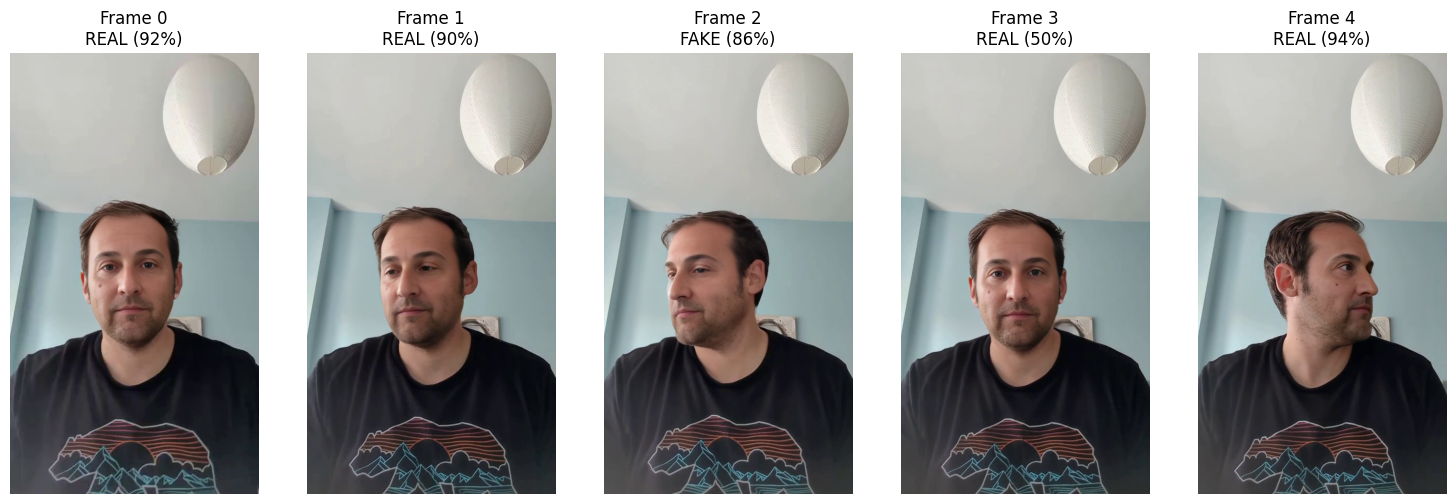

In [1]:
# ✅ IMPORTS
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pandas as pd

# ✅ CARGAR MODELO MesoNet
model_path = "/kaggle/input/mesonet/tensorflow2/default/1/fine_tuned_meso.h5"  # Cambia si es distinto
meso_model = load_model(model_path)
print(f"✅ Modelo cargado: {model_path}")

# ✅ RUTA DEL VIDEO
video_path = "/kaggle/input/video.mp4"  # Cambia esta ruta
assert os.path.exists(video_path), "❌ Ruta de video no encontrada."

# ✅ PARÁMETROS
NUM_FRAMES = 10  # Número de frames a analizar
FRAME_SIZE = (256, 256)  # Tamaño para MesoNet

# ✅ EXTRAER FRAMES DEL VIDEO
def extract_frames(video_path, num_frames=10):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, total_frames // num_frames)
    frames = []

    for i in range(0, total_frames, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)
        if len(frames) >= num_frames:
            break
    cap.release()
    return frames

frames = extract_frames(video_path, NUM_FRAMES)
print(f"📸 {len(frames)} frames extraídos")

# ✅ ANALIZAR FRAMES CON MESONET
results = []

for i, frame in enumerate(frames):
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb, FRAME_SIZE)
    x = resized.astype(np.float32) / 255.0
    x = np.expand_dims(x, axis=0)

    pred = meso_model.predict(x)[0][0]
    label = "REAL" if pred < 0.5 else "FAKE"
    confidence = 1 - pred if label == "REAL" else pred
    results.append((i, label, confidence))

# ✅ MOSTRAR RESULTADOS POR FRAME
df = pd.DataFrame(results, columns=["Frame", "Label", "Confidence"])
display(df.style.format({"Confidence": "{:.2%}"}).highlight_max(axis=0, subset=["Confidence"]))

# ✅ PROMEDIO GLOBAL
fake_probs = [c if l == "FAKE" else 1 - c for _, l, c in results]
mean_fake = np.mean(fake_probs)
final_label = "REAL" if mean_fake < 0.5 else "FAKE"

print(f"\n🔍 Resultado Final: {final_label} — {mean_fake:.2%} probabilidad de FAKE")

# ✅ VISUALIZAR ALGUNOS FRAMES
ncols = min(5, len(frames))
plt.figure(figsize=(15, 5))
for i in range(ncols):
    plt.subplot(1, ncols, i + 1)
    plt.imshow(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Frame {results[i][0]}\n{results[i][1]} ({results[i][2]:.0%})")
plt.tight_layout()
plt.show()
